In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sc_util import version

In [3]:
coarse_injection_site_mapping = {
    'VISp': 'VIS',  'PTLp': 'PTL', 'VISal': 'VIS', 'VISam': 'VIS', 
    'VISl': 'VIS',  'SSp-tr': 'SSp', 'ACAd': 'ACA', 'RSPv': 'RSP', 
    'ACAv': 'ACA', 'RSPagl': 'RSP', 'VISpm': 'VIS', 'RSPd': 'RSP',  
    'MOp': 'MO', 'ORBl': 'ORB', 'MOs': 'MO', 'SSp-ul': 'SSp', 'PL': 'PL', 
    'ORBvl': 'ORB', 'ORBm': 'ORB', 'SSp-ll': 'SSp', 'SSp-m': 'SSp', 
    'SSp-bfd': 'SSp', 'SSp-n': 'SSp', 'SSs': 'SSs', 'AUDd': 'AUD', 'AUDp': 'AUD', 'AUDv': 'AUD', 
    'TEa': 'TE', 'ILA': 'ILA', 'SNr': 'SN', 'SNr/SNc': 'SN', 'SC2': 'SC',
    'SC3': 'SC', 'SC1': 'SC', 'SC4': 'SC', 'SC3/PAG': 'SC', 'SC.l': 'SC', 'SC.cl/': 'SC', 'SC.cl': 'SC',
    'SC.cm': 'SC', 'SC.m': 'SC'
}

In [8]:
injection_sites_of_interest = ['RSPv', 'VISp', 'ACAd', 'MOp', 'SSp']
df = pd.read_csv('ctx_sc_cases_clean.csv', index_col=['Case ID', 'Channel'])
df['Actual Anatomical/ Injection Site Primary and Secondary'] = df['Actual Anatomical/ Injection Site'] + df['Actual Anatomical/ Injection Site Secondary']
print(pd.unique(df['Actual Anatomical/ Injection Site Primary and Secondary']))
print(pd.unique(df['Actual Anatomical/ Injection Site Secondary']))

['VISpmed' 'VISpcenter' nan 'VISal/p' 'VISl/pl' 'SSp-trlower' 'SSp-tr/ll'
 'ACAd/MOs' 'ACAd/PL' 'MOsACAd' 'MOsfef' 'SSp-bfd/trmed' 'SSp-bfdlat'
 'PTLpmed' 'SSp-trupper' 'TEacaudal' 'TEarostral' 'SNrvent-midd'
 'SNrvent-med' 'SNrdors-med' 'SC.cl/PAG']
['med' 'center' nan '/p' '/pl' 'lower' '/ll' '/MOs' '/PL' 'ACAd' 'fef'
 '/trmed' 'lat' 'upper' 'caudal' 'rostral' 'vent-midd' 'vent-med'
 'dors-med' 'PAG']


In [4]:
df_polar_level = pd.read_csv('polar_coordinates/polar_coordinates_ara_090.csv')
# convert to degrees
df_polar_level['theta'] = df_polar_level['theta'] * (180 / np.pi)
df_polar_level = df_polar_level.drop(labels='Unnamed: 0', axis=1)
# remove non cortical injection site
non_cortical = {'SNr', 'SNr/SNc', 'SC2', 'SC3', 'SC1', 'SC4', 'SC3/PAG', 'SC.l', 'SC.cl', 'SC.cl/', 'SC.cm', 'SC.m'}
df_polar_level = df_polar_level.loc[~df_polar_level['injection_site'].isin(non_cortical), :]
# add corse injection site column
df_polar_level['coarse_injection_site'] = df_polar_level['injection_site'].apply(lambda x: coarse_injection_site_mapping[x])
# add case_id_channel column
df_polar_level['case_channel'] = df_polar_level['case'] + '_ch' + df_polar_level['channel'].astype(str)
df_polar_level.head()

,case,case_slide,channel,injection_site,ara_level,theta,coarse_injection_site,case_channel
0,SW121221-02A,SW121221-02A_3_01,2,VISp,90,58.709210,VIS,SW121221-02A_ch2
1,SW121221-02A,SW121221-02A_3_01,2,VISp,90,58.688062,VIS,SW121221-02A_ch2
2,SW121221-02A,SW121221-02A_3_01,2,VISp,90,58.624596,VIS,SW121221-02A_ch2
3,SW121221-02A,SW121221-02A_3_01,2,VISp,90,58.616578,VIS,SW121221-02A_ch2
4,SW121221-02A,SW121221-02A_3_01,2,VISp,90,58.603433,VIS,SW121221-02A_ch2


In [ ]:
os.makedirs('plots/{}'.format(version))

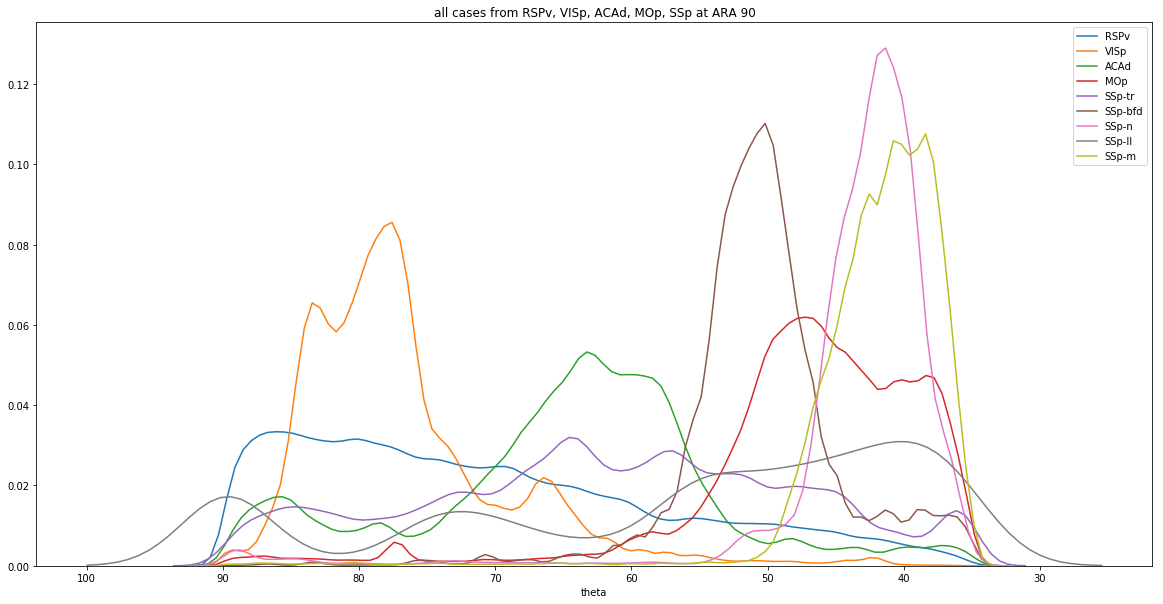

In [5]:
# distribution plot
fig, ax = plt.subplots(figsize=(20, 10))
injection_sites = ['RSPv', 'VISp', 'ACAd', 'MOp', 'SSp-tr', 'SSp-bfd', 'SSp-n', 'SSp-ll', 'SSp-m']
for injection_site in injection_sites:
    sns.distplot(df_polar_level.loc[df_polar_level['injection_site'] == injection_site, 'theta'], hist=False, label=injection_site, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])    
ax.legend()   
title = 'all_cases_composite_RSPv_VISp_ACAd_MOp_SSp_ARA_90'
_ = ax.set_title('allcases from RSPv, VISp, ACAd, MOp, SSp at ARA 90')

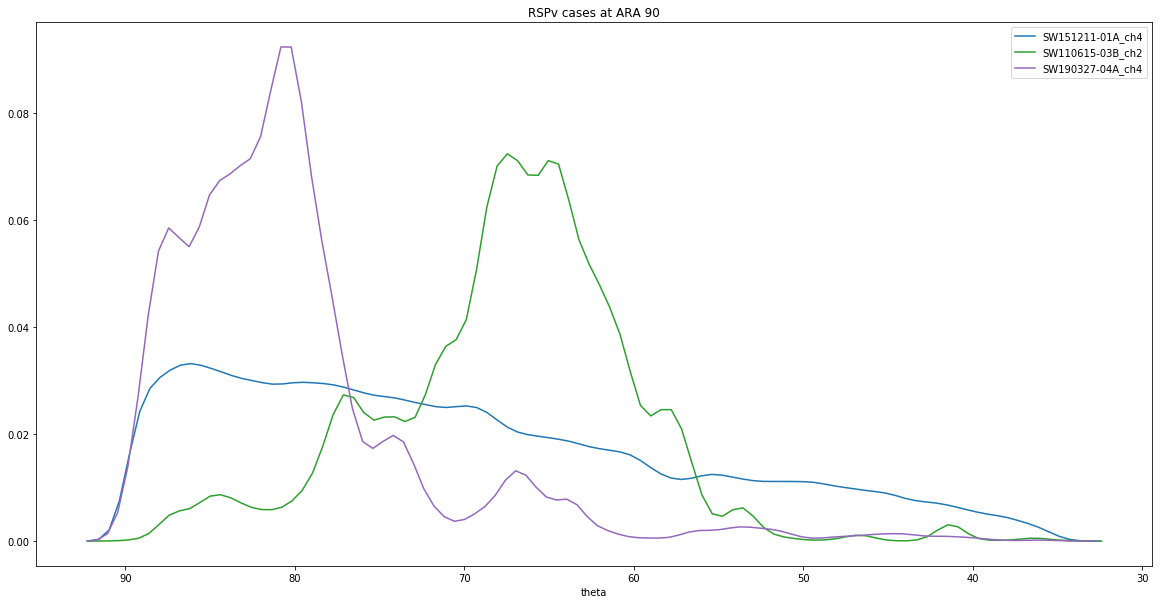

In [24]:
# distribution plot
fig, ax = plt.subplots(figsize=(20, 10))
injection_sites = ['RSPv', 'VISp', 'ACAd', 'MOp']
for case_channel in pd.unique(df_polar_level['case_channel']):
    sns.distplot(df_polar_level.loc[(df_polar_level['injection_site'] == 'RSPv') & (df_polar_level['case_channel'] == case_channel), 'theta'], hist=False, label=case_channel, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])  
ax.legend()   
_ = ax.set_title('RSPv cases at ARA 90')

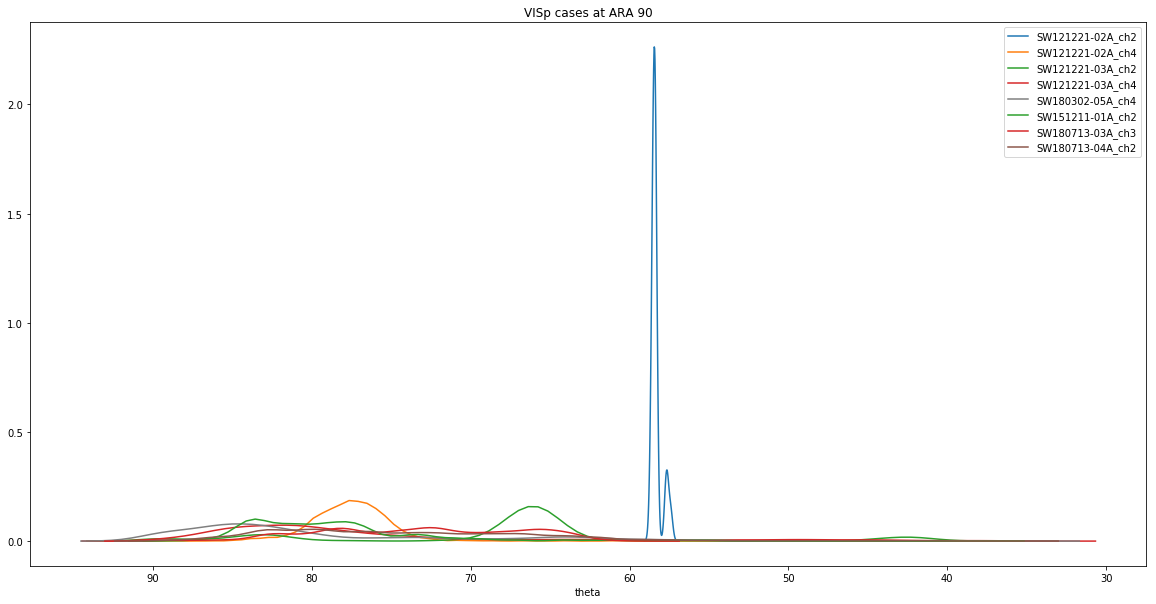

In [25]:
# distribution plot
fig, ax = plt.subplots(figsize=(20, 10))
injection_sites = ['RSPv', 'VISp', 'ACAd', 'MOp']
for case_channel in pd.unique(df_polar_level['case_channel']):
    sns.distplot(df_polar_level.loc[(df_polar_level['injection_site'] == 'VISp') & (df_polar_level['case_channel'] == case_channel), 'theta'], hist=False, label=case_channel, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])  
ax.legend()   
_ = ax.set_title('VISp cases at ARA 90')

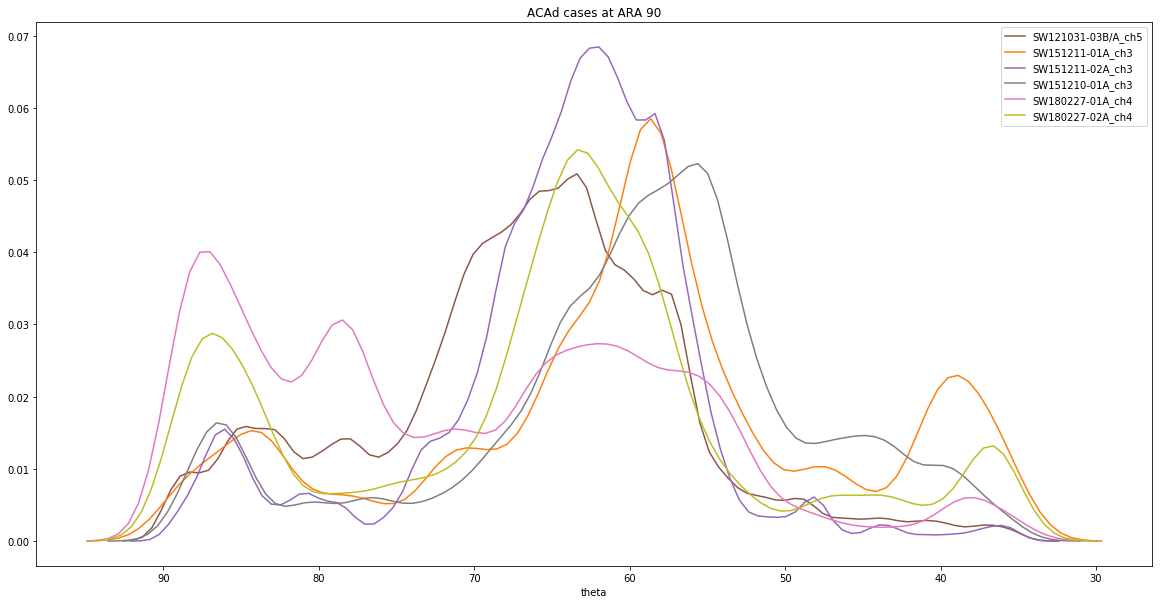

In [26]:
# distribution plot
fig, ax = plt.subplots(figsize=(20, 10))
injection_sites = ['RSPv', 'VISp', 'ACAd', 'MOp']
for case_channel in pd.unique(df_polar_level['case_channel']):
    sns.distplot(df_polar_level.loc[(df_polar_level['injection_site'] == 'ACAd') & (df_polar_level['case_channel'] == case_channel), 'theta'], hist=False, label=case_channel, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])  
ax.legend()   
_ = ax.set_title('ACAd cases at ARA 90')

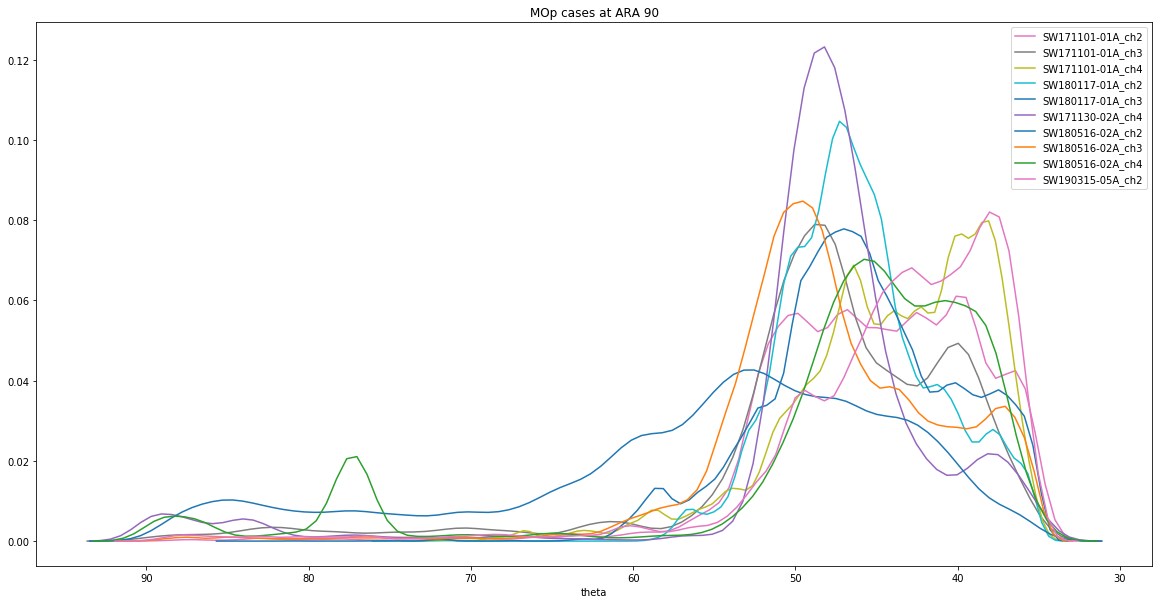

In [28]:
# distribution plot
fig, ax = plt.subplots(figsize=(20, 10))
injection_sites = ['RSPv', 'VISp', 'ACAd', 'MOp']
for case_channel in pd.unique(df_polar_level['case_channel']):
    sns.distplot(df_polar_level.loc[(df_polar_level['injection_site'] == 'MOp') & (df_polar_level['case_channel'] == case_channel), 'theta'], hist=False, label=case_channel, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])  
ax.legend()   
_ = ax.set_title('MOp cases at ARA 90')

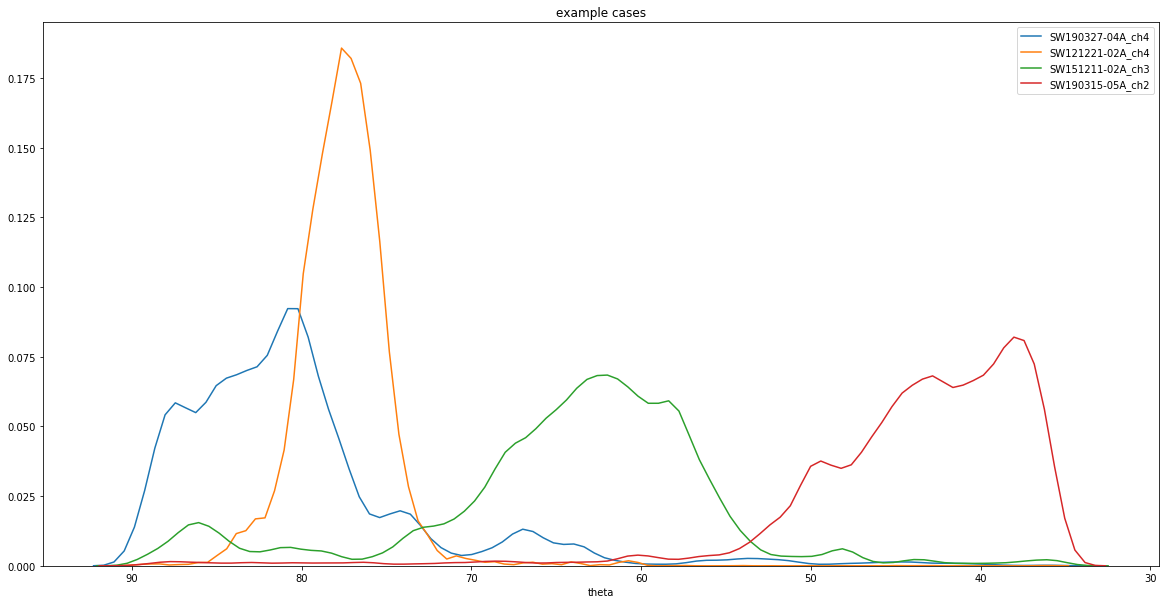

In [29]:
case_channels = ['SW190327-04A_ch4', 'SW121221-02A_ch4', 'SW151211-02A_ch3', 'SW190315-05A_ch2']
fig, ax = plt.subplots(figsize=(20, 10))
for case_channel in case_channels:
    sns.distplot(df_polar_level.loc[df_polar_level['case_channel'] == case_channel, 'theta'], hist=False, label=case_channel, ax=ax)
# flip x axis to have descending xticks    
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])  
ax.legend()   
_ = ax.set_title('example cases')